In [5]:
import sys
import os
import SimpleITK
import numpy
import matplotlib.pyplot
import subprocess
sys.path.append(os.path.join(os.path.expanduser('~'),'software','src','nixSuite','wrapper'))
import nixWrapper
nixWrapper.loadLibrary('labkeyInterface')
import labkeyInterface
net=labkeyInterface.labkeyInterface()
fconfig=os.path.join(os.path.expanduser('~'),'.labkey','network.json')
net.init(fconfig)
net.getCSRF()
import labkeyFileBrowser
sys.path.append(os.getcwd())
import downloadPatient
fb=labkeyFileBrowser.labkeyFileBrowser(net)
project='dinamic_spect/Patients'
locDir=os.path.join(os.path.expanduser('~'),'temp','dynamicSPECT')
import labkeyDatabaseBrowser
db=labkeyDatabaseBrowser.labkeyDB(net)
ds=db.selectRows(project,'study','Imaging',[])
patients=[row['aliasID'] for row in ds['rows']]

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 1f11a0b613d172716bb47acf122d5106


In [ ]:
#doAnalysis
import subprocess

patients=list(set(patients))
#this is if IVF is inferred from locations
runScript='doPixelAnalysis.sh'
#this is if IVF is taken from clusters
runScript='doPixelIVFAnalysis.sh'
scriptPath=os.path.join(os.path.expanduser('~'),\
                        'scripts','dynamicSPECT',runScript)
#patients1=['10KFMIR']
patients1=patients
for pId in patients1:
    if pId.find('8')==0:
        continue
    for sigma2 in [0.1,1.0,4.0]:
        print('{}/{}'.format(pId,sigma2))
        subprocess.run([scriptPath,pId,str(sigma2)], \
                         check=True, stdout=subprocess.PIPE)
    
   

In [20]:
def getPatientNIM(id):
    f=os.path.join(locDir,id,id+'Volume19.nrrd')
    im=SimpleITK.ReadImage(f)
    nim=SimpleITK.GetArrayFromImage(im)
    return nim

def getIWeights(locDir,p,nclass,realizationId,ic):
    fname='{}_{}_{}_center{}_centerWeigth.nrrd'.\
            format(p,nclass,realizationId+1,ic+1)
    uFile=os.path.join(locDir,p,fname)
            
    imU=SimpleITK.ReadImage(uFile)
    return SimpleITK.GetArrayFromImage(imU)



#gets weights by class for a particular realization and sigma2 averaging
def getWeights(project,locDir,p,nclass,realizationId,sigma2,na):
    #for w1, classes are in 0 to nclass-1 space
    idFilter={'variable':'aliasID','value':p,'oper':'eq'}
    ds=db.selectRows(project,'study','Segmentation',[idFilter])
    pts={r['regionId']:[float(x) for x in [r['x'],r['y'],r['z']]] for r in ds['rows']}
       
    w={region:numpy.zeros(nclass) for region in pts}
    na2=0.5*(na-1)
    
    for c in numpy.arange(nclass):
        fname='{}_{}_{}_center{}_centerWeigth.nrrd'.\
            format(p,nclass,realizationId+1,c+1)
        uFile=os.path.join(locDir,p,fname)
            
        imU=SimpleITK.ReadImage(uFile)
        nU=SimpleITK.GetArrayFromImage(imU)
        
        
        for region in w:
            #print(pts[region])
            idx=[int(x) for x in pts[region]]
            #print(nU[tuple(idx)])
            
            #gaussian weighted summation of surrounding pixels
            fidx=numpy.zeros(3)
            fs=0
            for i in numpy.arange(na):
                fidx[0]=idx[0]+(i-na2)
                for j in numpy.arange(na):
                    fidx[1]=idx[1]+(j-na2)
                    for k in numpy.arange(na):
                        fidx[2]=idx[2]+(k-na2)
                        fidx=[int(x) for x in fidx]
                        fw=numpy.array(fidx)-numpy.array(pts[region])
                        fw=numpy.exp(-0.5*sum(fw*fw)/sigma2);
                        fs+=fw
                        w[region][c]+=fw*nU[tuple(fidx)]
                        #print('{}/{}: {:.2f} {:.2g}'.format(idx,fidx,fw,nU[tuple(fidx)]))
            w[region][c]/=fs
            
            
    return w

#gets fitPar for a particular realization
def getFitPar(locDir,p,nclass,realizationId):
    #fitGoodnes A tau alpha delay [k1 BVF k2 delay]xNcenters
    fname='{}_{}_{}_fitParFinal.txt'.format(p,nclass,realizationId+1)
    uFile=os.path.join(locDir,p,fname)
    return numpy.genfromtxt(uFile,delimiter='\t')

def getFitParIVF(locDir,p,nclass,realizationId):
    #fitGoodnes A tau alpha delay [k1 BVF k2 delay]xNcenters
    fname='{}_{}_{}_IVF_fitParFinal.txt'.format(p,nclass,realizationId+1)
    uFile=os.path.join(locDir,p,fname)
    return numpy.genfromtxt(uFile,delimiter='\t')

def getFitParPixel(locDir,p,nclass,sigma2):
    sigmaCode='{:.2f}'.format(sigma2)
    sigmaCode=sigmaCode.replace(".","p")
    fname='{}_{}_{}_Pixel_fitParFinal.txt'.format(p,nclass,sigmaCode)
    uFile=os.path.join(locDir,p,fname)
    return numpy.genfromtxt(uFile,deliiter='\t')

def getFitParPixelIVF(locDir,p,nclass,sigma2):
    sigmaCode='{:.2f}'.format(sigma2)
    sigmaCode=sigmaCode.replace(".","p")
    fname='{}_{}_{}_PixelIVF_fitParFinal.txt'.format(p,nclass,sigmaCode)
    uFile=os.path.join(locDir,p,fname)
    return numpy.genfromtxt(uFile,delimiter='\t')

def getK1(fitPar,iclass):
    #fitGoodnes A tau alpha delay [k1 BVF k2 delay]xNcenters
    #0 to nclass-1 space
    return fitPar[4*iclass+5]

def calculateK1(w,fitPar):
    #calculateK1 for region weights
    #return the k1 that belongs to the 
    #maximum class in region (M) and 
    #a weighted average (W)
    k1={region:{'M':0,'W':0} for region in w}
    for region in w:
        cmax=numpy.argmax(w[region])
        k1[region]['M']=getK1(fitPar,cmax)
        fs=0
        for c in numpy.arange(len(w[region])):
            fs+=w[region][c]*getK1(fitPar,c)
        k1[region]['W']=fs
    return k1

def getPatientValuesByNclass(project,locDir,p,nclass,nrealizations,sigma2,na):
    #summary script
    #project/locDir and p identify patient
    #nclass and nrealizations select strategy
    #sigma2 is for combining output from adjacent pixels
    #na is neighborhood size where smoothing/combination is done
    k1={}
    for i in numpy.arange(nrealizations):
        w=getWeights(project,locDir,p,nclass,i,sigma2,na)
        fitPar=getFitParIVF(locDir,p,nclass,i)
        qk1=calculateK1(w,fitPar)
        for region in w:
            for type in qk1[region]:
                try:
                    k1[region][type].append(qk1[region][type])
                except KeyError:
                    k1={region:{type:[] for type in qk1[region]} for region in w}
                    print(type)
                    k1[region][type].append(qk1[region][type])
        print('[{}] {}/{}'.format(nclass,i+1,nrealizations))
    return k1   

def getSummaryPatientValuesByNclass(project,locDir,p,nclass,nrealizations,sigma2,na):
    #summary script, same arguments as above
    #also return deviation over realization
    k1=getPatientValuesByNclass(project,locDir,p,nclass,nrealizations,sigma2,na)
    avgType=['M','W']
    summaryK1={type:{region:{
        'mean':numpy.mean(k1[region][type]), 
        'std':numpy.std(k1[region][type]), 
        'median':numpy.median(k1[region][type])} for region in k1}
               for type in avgType}
    
    return summaryK1

def fullSummary(project,locDir,patientList,classes,nr,sigma2,na):
    return \
        {p:{c:getSummaryPatientValuesByNclass(project,locDir,p,c,nr,sigma2,na) for c in classes} for p in patientList}
          
def storeSummary(db,project,locDir,k1,sigma2,na):
    dsM=db.selectRows(project,'study','Imaging',[])
    for p in k1:
        idFilter={'variable':'aliasID','value':p,'oper':'eq'}
        for c in k1[p]:
            cFilter={'variable':'nclass','value':str(c),'oper':'eq'}
            for t in k1[p][c]:
                tFilter={'variable':'option','value':t,'oper':'eq'}
                for r in k1[p][c][t]:
                    rFilter={'variable':'regionId','value':str(r),'oper':'eq'}
                    ds=db.selectRows(project,'study','Summary',[idFilter,cFilter,tFilter,rFilter])
                    if len(ds['rows'])>0:
                        qrow=ds['rows'][0]
                        mode='update'
                    else:
                        frow=[r for r in dsM['rows'] if r['aliasID']==p]
                        qrow={'aliasID':p,'nclass':c,'option':t,'regionId':r}
                        qrow['SequenceNum']=frow[0]['SequenceNum']+c+0.001*r
                        if t=='M':
                            qrow['SequenceNum']+=0.0001
                        qrow['PatientId']=frow[0]['PatientId']
                        mode='insert'
                    for v in k1[p][c][t][r]:
                        qrow[v]=k1[p][c][t][r][v]
                    qrow['sigma2']=sigma2
                    qrow['na']=na
                    db.modifyRows(mode,project,'study','Summary',[qrow])
    
def summaryPixelIVF(project,locDir,patientList,sigma2List,na):
     return \
        {p:{sigma2:getPixelIVF(project,locDir,p,sigma2,na) for sigma2 in sigma2List} for p in patientList}
    
def storeIVF(db,project,locDir,k1):
    dsM=db.selectRows(project,'study','Imaging',[])
    for p in k1:
        idFilter={'variable':'aliasID','value':p,'oper':'eq'}
        for s2 in k1[p]:
            sigmaFilter={'variable':'sigma2','value':str(s2),'oper':'eq'}
            for r in k1[p][s2]:
                rFilter={'variable':'regionId','value':str(r),'oper':'eq'}
                typeFilter={'variable':'option','value':'D','oper':'eq'}
                ds=db.selectRows(project,'study','Summary',[idFilter,sigmaFilter,rFilter,typeFilter])
                if len(ds['rows'])>0:
                    qrow=ds['rows'][0]
                    mode='update'
                else:
                    frow=[r for r in dsM['rows'] if r['aliasID']==p]
                    qrow={'aliasID':p,'sigma2':s2,'regionId':r}
                    qrow['SequenceNum']=40+frow[0]['SequenceNum']+0.01*r+0.001*s2
                    qrow['PatientId']=frow[0]['PatientId']
                    mode='insert'
                qrow['mean']=k1[p][s2][r]
                qrow['na']=7
                qrow['nclass']=16
                qrow['option']='D'
                db.modifyRows(mode,project,'study','Summary',[qrow])

def getPixelIVF(project,locDir,p,sigma2,na):
    fitPar=getFitParPixelIVF(locDir,p,16,sigma2)
    idFilter={'variable':'aliasID','value':p,'oper':'eq'}
    ds=db.selectRows(project,'study','Segmentation',[idFilter])
    k1={r['regionId']:getK1(fitPar,r['regionId']) for r in ds['rows']}
    return k1

In [ ]:
pat=[p for p in patients if p.find('8')!=0]
k1=summaryPixelIVF(project,locDir,pat,[0.1],7)
storeIVF(db,project,locDir,k1)

In [ ]:
pat=[p for p in patients if p.find('8')!=0]
k1=fullSummary(project,locDir,pat,[10],20,0.1,3)
storeSummary(db,project,locDir,k1,0.1,3)


In [107]:
print(k1)

{'M': {0: {'mean': 0.005371908478823275, 'std': 0.0005748154115907079, 'median': 0.00504829351328475}, 1: {'mean': 0.00398706780698255, 'std': 0.0008592694250527332, 'median': 0.003388404180814905}, 2: {'mean': 0.0037767548460013053, 'std': 0.0006276175516250823, 'median': 0.004138535106155311}, 3: {'mean': 0.0045120019537560705, 'std': 0.0007593001890057208, 'median': 0.004904191257967345}, 4: {'mean': 0.0031040814064716474, 'std': 0.0001765662651125499, 'median': 0.00301590732317976}, 5: {'mean': 0.0045120019537560705, 'std': 0.0007593001890057208, 'median': 0.004904191257967345}, 6: {'mean': 0.0031040814064716474, 'std': 0.0001765662651125499, 'median': 0.00301590732317976}, 7: {'mean': 0.0031040814064716474, 'std': 0.0001765662651125499, 'median': 0.00301590732317976}, 8: {'mean': 0.0031040814064716474, 'std': 0.0001765662651125499, 'median': 0.00301590732317976}, 9: {'mean': 0.0031040814064716474, 'std': 0.0001765662651125499, 'median': 0.00301590732317976}, 10: {'mean': 0.0034925

0.02223504
0.02223504


/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


0.4418241525813627
0.34392268845874496
0.44668512187675746
0.4277373071517828
0.3922308796145302
0.35643425292374326
0.3692802456593414
0.31520469737807355
0.4654286761032285
0.7829711283052362
0.29574684452011624
0.32465688583552055
0.4998691162413557
0.45862342417011315
0.5354598797118066
0.29275341177289665


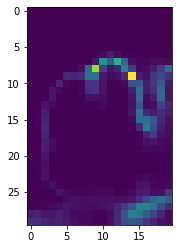

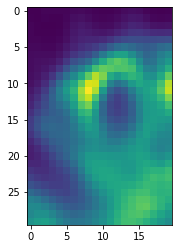

In [56]:
import matplotlib
p='7TMOBR'
sy=28
realizationId=5
nclass=30
nu=getIWeights(locDir,p,30,realizationId,4)
nim=getPatientNIM(p)
cut0=20
w0=20
cut1=0
fw=40
idx=[7,28,34]
print(nu[7,28,34])
print(nu[tuple(idx)])
w=getWeights(project,locDir,p,nclass,realizationId,0.1,7)
for r in w:
    print(numpy.max(w[r]))
matplotlib.pyplot.imshow(nu[:,sy,cut0:cut0+w0])
matplotlib.pyplot.show()
matplotlib.pyplot.imshow(nim[:,sy,cut0:cut0+w0])
matplotlib.pyplot.show()

In [93]:
k1=combinePatient(project,locDir,'7TMMIR',[10,20,30],20,4.0,7)

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


M
[10] 20/20
[20] 20/20
[30] 20/20


In [94]:
avgType=['M','W']
meanK1={type:{region:numpy.mean(k1[region][type]) for region in k1} for type in avgType}
stdK1={type:{region:numpy.std(k1[region][type]) for region in k1} for type in avgType}
print(meanK1['M'])
print(stdK1['M'])


{0: 0.006172951839546806, 1: 0.0011293802007511504, 2: 0.0034521499735888144, 3: 0.0042544572958967365, 4: 0.0035312206174353085, 5: 0.0042544572958967365, 6: 0.0030514161815550344, 7: 0.0013307214487837872, 8: 0.003330571003684981, 9: 0.0031176179941574842, 10: 0.0020333718489625023, 11: 0.00333907520086298, 12: 0.007351435428832242, 13: 0.0038036462072787995, 14: 0.003625240367164753, 15: 0.0028970199562430546}
{0: 0.0006961087295939239, 1: 0.00031228541489592706, 2: 0.0004510546128805069, 3: 0.0005051282237067151, 4: 0.0004762660491350051, 5: 0.0005051282237067151, 6: 0.0005505760968232114, 7: 0.00032581639272840707, 8: 0.0005191027850853616, 9: 0.0007540860325457227, 10: 0.00032310962085205355, 11: 0.00038986355593399486, 12: 0.0027199019036271716, 13: 0.000548794240952012, 14: 0.0005487268424526743, 15: 0.0006667221336658735}


[0.00252038792282219, 0.00151611481573515, 0.00254164182147798, 0.00186663983190471, 0.00404895113316396, 0.0020328762566657, 0.00190085158556521, 0.00249521000442543, 0.00157109119636192, 0.00386999102896687, 0.00282258552513781, 0.00334338605677939, 0.00304450254908494, 0.00187659097886802, 0.00202826225861249, 0.0016204124091652]
0.00252038792282219 0 0.00544315853082935
0.00151611481573515 8 0.00204586967629601
0.00254164182147798 1 0.00249553160944056
0.00186663983190471 8 0.00204586967629601
0.00404895113316396 7 0.00310949812694919
0.0020328762566657 8 0.00204586967629601
0.00190085158556521 2 0.0025554273008312
0.00249521000442543 7 0.00310949812694919
0.00157109119636192 9 0.00148953599268332
0.00386999102896687 0 0.00544315853082935
0.00282258552513781 7 0.00310949812694919
0.00334338605677939 1 0.00249553160944056
0.00304450254908494 1 0.00249553160944056
0.00187659097886802 2 0.0025554273008312
0.00202826225861249 8 0.00204586967629601
0.0016204124091652 9 0.001489535992683

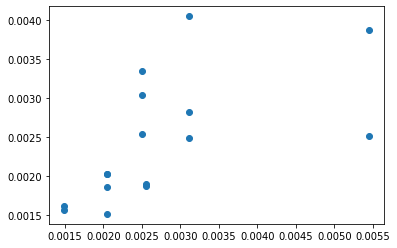

In [79]:
#k1=combinePatient(project,locDir,'7TMMIR',[10],20,4.0,7)
realizationId=3
c=10
p='7TMOBR'
w=getWeights(project,locDir,p,c,realizationId,0.1,3)
wc={region:numpy.argmax(w[region]) for region in w}
fitPar=getFitParIVF(locDir,p,c,realizationId)
qk1=calculateK1(w,fitPar)
k1p=getPixelIVF(project,locDir,p,4.0,7)
pk=list(k1p.values())
print(pk)
ck=[qk1[region]['M'] for region in qk1]
matplotlib.pyplot.scatter(ck,pk)
for region in w:
    print('{} {} {}'.format(k1p[region],wc[region],qk1[region]['M']))

In [136]:
k1p=getPixelIVF(project,locDir,'7TMMIR',4.0,7)

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


In [156]:
for r in k1:
    print('{} {} {}/{}'.format(k1p[r], qk1[r]['M'] ,numpy.median(k1[r]['M'][10:20]),numpy.std(k1[r]['M'])))

0.00252038792282219 0.00821063685487176 0.000769278586995102/0.0003330083431359072
0.00151611481573515 3.10567836690838e-05 7.88785113142985e-06/1.9000844446763202e-06
0.00254164182147798 3.10567836690838e-05 7.88785113142985e-06/1.9000844446763202e-06
0.00186663983190471 0.00821063685487176 0.000769278586995102/0.0001671052167808519
0.00404895113316396 0.0122210526169817 0.000769278586995102/0.0001671052167808519
0.0020328762566657 0.0329991638607282 0.00219782291835452/0.0009453421745505919
0.00190085158556521 3.10567836690838e-05 7.88785113142985e-06/1.9000844446763202e-06
0.00249521000442543 0.0170371097144494 0.000769278586995102/0.0001671052167808519
0.00157109119636192 3.10567836690838e-05 7.88785113142985e-06/1.9000844446763202e-06
0.00386999102896687 0.22232351448649 0.00260465709367942/0.0010770771831046689
0.00282258552513781 0.0261881964613408 0.002167764950618855/0.0006606993805304795
0.00334338605677939 0.00388464867694823 7.88785113142985e-06/0.0003179710076941252
0.0030

In [45]:
numpy.zeros(3)

array([0., 0., 0.])